## Bagging Classifier (from Decision Tree)

Here we create a BaggingClassifier with a DecisionTreeClassifier with 
- max_depth = 8
- n_estimators = 40

## Table of Content

<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

pd.set_option('use_inf_as_na', True)
from collections import Counter

In [3]:
raw_data = pd.read_pickle(r'..\HW1_Decision Tree\dataset.pkl')

In [4]:
data = raw_data[raw_data['market_cap'] > 1000.0]

In [5]:
data.fillna(0.0, inplace=True)

c:\users\gulishana\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


### Insert a column in the data set with entries: (1) 2 if the stock return is more then 5% higher than the SPY return; (2) 1 if it is more than 1% but less than 5% higher; (3) 0 if it is between -1% and 1%; (4) -2 if the stock underperforms the SPY by more than -5%; (5) -1 if the performance is between -1% and -5%

In [6]:
def f(x):
    if x > 0.05:
        return 2
    elif x >0.01 and x<= 0.05:
        return 1
    elif x > -0.01 and x<= 0.01:
        return 0
    elif x > -0.05 and x<= -0.01:
        return -1
    else:
        return -2

In [7]:
data['rel_performance'] = data['pred_rel_return'].apply(f)

c:\users\gulishana\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
data.reset_index(inplace=True,)
data.set_index('date',inplace=True)

In [9]:
data.head()

,ticker,actq,apq,atq,ceqq,cheq,cogsq,csh12q,cshfdq,cshiq,...,sector_code_817.0,sector_code_822.0,sector_code_823.0,sector_code_825.0,sector_code_830.0,sector_code_835.0,sector_code_840.0,sector_code_845.0,sector_code_850.0,rel_performance
date,,,,,,,,,,,,,,,,,,,,,
2000-02-09,CSCO,7722.000,482.000,21391.000,16523.000,3968.000,1422.000,3374.1250,3648.000,3445.000,...,0,0,0,0,0,0,0,0,0,-1
2000-02-09,ROP,172.725,19.662,474.649,239.432,3.198,47.634,30.2688,31.217,0.000,...,0,0,0,0,0,0,0,0,0,2
2000-02-10,CMOS,240.767,27.044,376.536,209.411,68.625,43.023,21.4360,23.753,0.000,...,0,0,0,0,0,0,0,0,0,2
2000-02-11,DELL,7681.000,3538.000,11471.000,5308.000,4132.000,5452.000,2536.0000,2731.000,2575.000,...,0,0,0,0,0,0,0,0,0,2
2000-02-15,VAL,507.082,139.497,1094.080,402.382,27.605,221.366,43.1858,43.687,53.321,...,0,0,0,0,0,0,0,0,0,1


### Use the period 2007-04-30 to 2010-04-30 to train the model

In [10]:
df_1 = data.loc['2007-04-30':'2010-04-30']

### Use the period 2010-07-31 to 2010-10-31 to find the optimal features

In [11]:
df_valid = data.loc['2010-07-31':'2010-10-31']

In [12]:
train_1 = df_1.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)


valid = df_valid.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

In [13]:
train_1_stock_returns = df_1['next_period_return']
valid_stock_returns = df_valid['next_period_return']

In [14]:
y_1 = df_1['rel_performance']
y_valid = df_valid['rel_performance']

In [15]:
y_1 = y_1.values
y_valid = y_valid.values

### Create a DecisionTreeClassifier with `max_depth = 8`

In [16]:
t_clf = DecisionTreeClassifier(min_samples_leaf=1800, max_depth=8)

### Create a BaggingClassifier with # `n_estimators = 40` DecisionTreeClassifiers

In [17]:
bg_clf = BaggingClassifier(t_clf, n_estimators=40, oob_score=True, random_state=123, n_jobs=-1)

In [18]:
bg_clf.fit(train_1,y_1)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1800, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=40, n_jobs=-1, oob_score=True,
         random_state=123, verbose=0, warm_start=False)

In [19]:
bg_clf.score(train_1,y_1)

0.4171389425172822

In [20]:
bg_clf.score(valid,y_valid)

0.37124463519313305

In [21]:
pred_valid = bg_clf.predict(valid)

In [22]:
Counter(pred_valid)

Counter({2: 1387, -2: 11})

In [23]:
Counter(y_valid)

Counter({-1: 191, 2: 522, 1: 209, 0: 134, -2: 342})

In [24]:
bg_clf.oob_score_

0.41576882356604594

In [25]:
confusion_matrix(y_valid,pred_valid)

array([[  3,   0,   0,   0, 339],
       [  2,   0,   0,   0, 189],
       [  0,   0,   0,   0, 134],
       [  0,   0,   0,   0, 209],
       [  6,   0,   0,   0, 516]], dtype=int64)

In [26]:
def baggingtree_feat_importance(m, df):
    feature_importances = []
    for est in m.estimators_:
        fi = est.feature_importances_
        feature_importances.append(fi)
    feature_importances = np.array(feature_importances)
    print(feature_importances.shape)
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp':np.mean(feature_importances,axis=0)}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

In [27]:
fi = baggingtree_feat_importance(bg_clf,train_1)

(40, 725)


In [28]:
features = fi[(fi['feat_imp'] > 0.003)]
#features

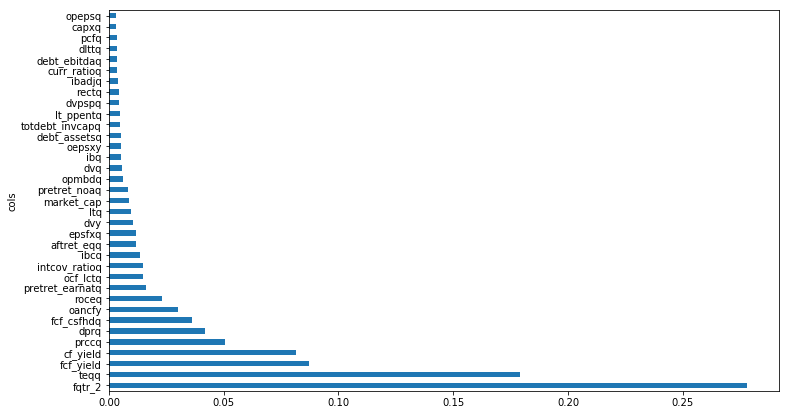

In [29]:
plot_fi(features);

In [30]:
len(features['cols'].values)

35

In [31]:
train_1 = train_1[features['cols'].values]
valid = valid[features['cols'].values]

In [32]:
bg_clf.fit(train_1,y_1)
bg_clf.score(train_1,y_1)

0.4171389425172822

In [33]:
pred_valid = bg_clf.predict(valid)
bg_clf.score(valid,y_valid)

0.37124463519313305

In [34]:
bg_clf.oob_score_

0.41576882356604594

In [35]:
(pred_valid * valid_stock_returns).sum()

347.13709200000005

In [36]:
def profit_importance(t,df,rets):
#     np.random.seed(123)
    profit = []
    for col in df.columns:
        prof = []
        for _ in range(10):
            X = df.copy()
            X[col] = np.random.permutation(df[col].values)
            prediction = t.predict(X)
            prof.append((prediction * rets).sum())
        profit.append(np.mean(prof))
    return profit

In [37]:
def baggingtree_profit_importance(m, df,rets):
    return pd.DataFrame({'cols':df.columns, 'pi_imp':profit_importance(m,df,rets)}
                       ).sort_values('pi_imp', ascending=True)

In [38]:
pi = baggingtree_profit_importance(bg_clf,valid,df_valid['next_period_return'])
pi

,cols,pi_imp
5,dprq,346.621172
17,market_cap,346.828784
32,pcfq,347.137092
31,dlttq,347.137092
30,debt_ebitdaq,347.137092
29,curr_ratioq,347.137092
28,ibadjq,347.137092
27,rectq,347.137092
25,lt_ppentq,347.137092
24,totdebt_invcapq,347.137092


In [39]:
profits = []
feat=[]

train = train_1.copy()
validation = valid.copy()

while len(train.columns)>1:

    col_to_drop = pi.iloc[-1]['cols']
    train.drop(col_to_drop,axis=1,inplace=True)
    validation.drop(col_to_drop,axis=1,inplace=True)
        
    bg_clf.fit(train,y_1)
    pi = baggingtree_profit_importance(bg_clf,validation,df_valid['next_period_return'])

    pred_valid = bg_clf.predict(validation)
        
    print((pred_valid * df_valid['next_period_return']).sum())
    profits.append((pred_valid * df_valid['next_period_return']).sum())
    feat.append(train.columns)

347.13709200000005
348.869196
347.51155200000005
348.39252
349.230856
346.19656
346.109568
344.72669600000006
339.001052
341.626184
352.34586
352.34586
352.34586
352.34586
352.34586
352.34586
352.34586
352.34586
352.34586
352.34586
352.34586
352.34586
352.34586
352.34586
352.34586
352.34586
352.34586
352.34586
352.34586
352.34586
352.34586
352.34586
352.34586
352.34586


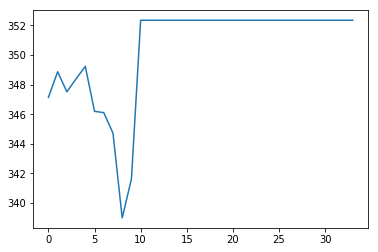

In [40]:
plt.plot(profits);

In [41]:
n = np.argmax(profits)
optim_feats = feat[n]
max_profits = profits[n]

In [42]:
print(max_profits)
print(optim_feats)

352.34586
Index(['cf_yield', 'prccq', 'intcov_ratioq', 'ibcq', 'aftret_eqq', 'epsfxq',
       'ltq', 'market_cap', 'pretret_noaq', 'opmbdq', 'dvq', 'ibq', 'oepsxy',
       'debt_assetsq', 'totdebt_invcapq', 'lt_ppentq', 'dvpspq', 'rectq',
       'ibadjq', 'curr_ratioq', 'dlttq', 'pcfq', 'capxq', 'opepsq'],
      dtype='object')


In [43]:
train_1_optim = train_1[optim_feats]
valid_optim = valid[optim_feats]

bg_clf.fit(train_1_optim,y_1)
print("The score of training is", bg_clf.score(train_1_optim,y_1))

pred_valid_tree = bg_clf.predict(valid_optim)
print("The score of validation is", bg_clf.score(valid_optim,y_valid))

(pred_valid_tree * valid_stock_returns).sum()

The score of training is 0.413339976334309
The score of validation is 0.37339055793991416


352.34586

In [44]:
from scipy.cluster import hierarchy as hc
import scipy.stats

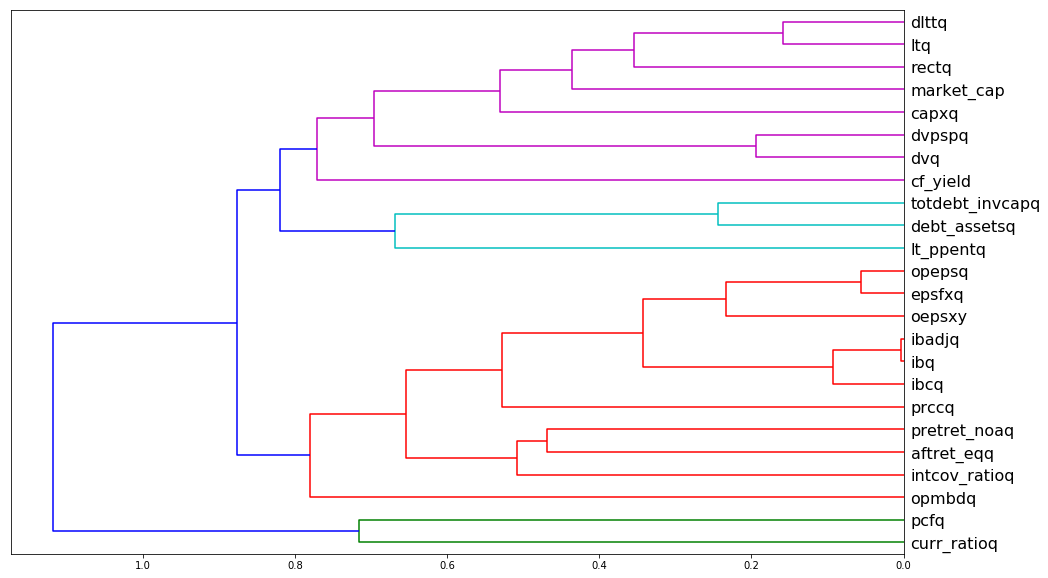

In [45]:
corr = np.round(scipy.stats.spearmanr(train_1_optim).correlation,4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=train_1_optim.columns, orientation='left', leaf_font_size=16)
plt.show()
# x=0: strongly correlated

### Backtest the performance of the model with the optimal features over the period 2010-01-01 to 2018-12-31    
There are #(5*4 + 3 = 23) training frames in total

In [46]:
# backtest
start_dates = [pd.to_datetime('2010-01-01') + pd.DateOffset(months = 3 * i) for i in range(23)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [47]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

In [48]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [49]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [50]:
training_labels = [d['rel_performance'].values for d in training_frames]

In [51]:
opt_training_data = [t[optim_feats] for t in training_data]
opt_test_data = [v[optim_feats] for v in test_data]

In [52]:
P_L = []
x = [1]
ret = []

for i in range(len(training_labels)):
    bg_clf.fit(opt_training_data[i],training_labels[i])
    pred_i = bg_clf.predict(opt_test_data[i])
    profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
    P_L.append(profit_i)
    num_positions = len(pred_i)
    ret.append((1.0/num_positions) * profit_i)
    x.append(x[i] + (x[i]/num_positions) * profit_i)


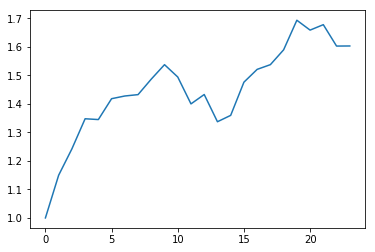

In [53]:
plt.plot(x);

In [54]:
SPY = pd.read_pickle(r'..\HW1_Decision Tree\SPY_cum_ret.pkl')
SPY = SPY.loc['2013-01-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

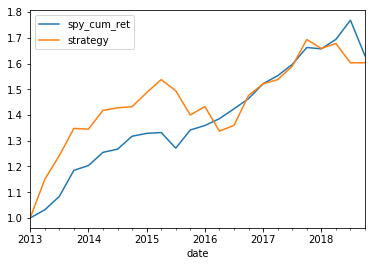

In [55]:
SPY.plot();

In [56]:
SPY = SPY.resample('Y').ffill()

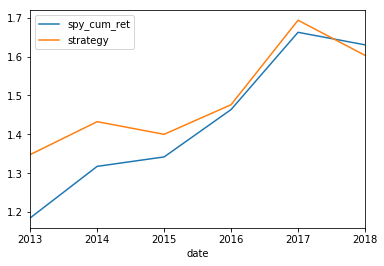

In [57]:
SPY.plot();

In [58]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.43029514298465815


In [59]:
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
print('SP Sharpe Ratio: ',(SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std())

SP Sharpe Ratio:  0.9675171990497208


In [60]:
x[-1]

1.603314946666803

In [61]:
SPY['spy_cum_ret'][-1]

1.6303419999999993

In [62]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

1.5882544107898242

In [63]:
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

-2.841721279381162

In [64]:
alpha = np.mean(residual_ret)
alpha

-0.09038471183692

## Results
- The score of validation is 0.3734
- Sharpe ratio for the strategy is 0.4303
- Sharpe ratio for SPY is 0.9675
- Information ratio for the strategy is -2.8417
- Alpha for the strategy is -0.0904